In [63]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from transformers import AutoModelForVision2Seq, AutoProcessor
from vla.action_tokenizer import RLbenchPoseTokenizer
from vla.base_prompter import PurePromptBuilder
from PIL import Image

In [3]:
path = './datasets/pick_described_object/train_data.pt'
model_path = '/media/lawrence/Work/checkpoints/openvla-7b'

In [87]:
processor = AutoProcessor.from_pretrained("/media/lawrence/Work/checkpoints/ecot-openvla-7b-bridge", trust_remote_code=True)    

In [88]:
processor.tokenizer.add_tokens(['<action>', '</action>', '<gripper>', '</gripper>', '<object>', '</object>', '<target>', '</target>'])

8

In [89]:
action_tokenizer = RLbenchPoseTokenizer(processor.tokenizer)

In [8]:
# print(action_tokenizer(test_pose1))
# processor.tokenizer(f"<action>{action_tokenizer(test_pose1)} </action>")

In [9]:
output = torch.tensor([[1, 31627, 31711, 31829, 31898, 31941, 31898, 31998, 32002, 1],
    [1, 32001, 31627, 31711, 31829, 31898, 31941, 31898, 31998, 32002]])

#the index between <action> and </action> is the action token


In [10]:
action_start = (output == 32001).to(torch.int).argmax(dim=1)
action_end = (output == 32002).to(torch.int).argmax(dim=1)
action_mask = torch.zeros_like(output)
for i in range(output.size(0)):
    action_mask[i, action_start[i]:action_end[i]+1] = 1

In [11]:
(output == 32001).to(torch.int)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [12]:
#generate a tensor that has the same shape as the output tensor
# true where between action_start and action_end


In [13]:
processor.tokenizer('chocolate jello POSE: <action>@#$!@# </action>')

{'input_ids': [1, 521, 542, 23167, 432, 3156, 21521, 1660, 29901, 32001, 29992, 29937, 29938, 29991, 29992, 29937, 32002], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
data = torch.load(path)

In [17]:
data.keys()

dict_keys(['imgs', 'instructions', 'cots', 'target_item_poses', 'gripper_poses', 'basket_positions', 'actions'])

In [23]:
processor.tokenizer(f"<object>{action_tokenizer(data['target_item_poses'][0])} </object>")

{'input_ids': [1, 32005, 31667, 31779, 31827, 31948, 31948, 31909, 32006], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [57]:
processor.tokenizer(f"<target>{action_tokenizer(data['basket_positions'][0])} </target>")

{'input_ids': [1, 32007, 31628, 31715, 31848, 32008], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [31]:
processor.tokenizer(f"<gripper>{action_tokenizer(data['gripper_poses'][0])} </gripper>")

{'input_ids': [1, 32003, 31669, 31774, 31836, 31898, 31948, 31931, 31999, 32004], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [33]:
processor.tokenizer(data['cots'][0].format(target_item_pose = f"<object>{action_tokenizer(data['target_item_poses'][0])} </object>",
                       basket_position = f"<target>{action_tokenizer(data['basket_positions'][0])} </target>",
                       gripper_pose = f"<gripper>{action_tokenizer(data['gripper_poses'][0])} </gripper>",
                       action = f"<action>{action_tokenizer(data['actions'][0])} </action>"))

{'input_ids': [1, 29871, 13, 305, 542, 23167, 432, 3156, 21521, 1660, 29901, 32005, 31667, 31779, 31827, 31948, 31948, 31909, 32006, 13, 29933, 3289, 29968, 2544, 21521, 1660, 29901, 32007, 31628, 31715, 31848, 32008, 13, 29954, 3960, 29925, 13171, 21521, 1660, 29901, 32003, 31669, 31774, 31836, 31898, 31948, 31931, 31999, 32004, 13, 1525, 29909, 3094, 4214, 29901, 402, 374, 2496, 7359, 29915, 29873, 25274, 287, 278, 521, 542, 23167, 432, 3156, 13, 20633, 29911, 3289, 17557, 29901, 29871, 29896, 29889, 16619, 304, 278, 521, 542, 23167, 432, 3156, 322, 5839, 372, 701, 29889, 29871, 29906, 29889, 16619, 975, 278, 25972, 29889, 29871, 29941, 29889, 22150, 278, 521, 542, 23167, 432, 3156, 297, 278, 25972, 29889, 13, 22484, 29450, 317, 4330, 29925, 29901, 25249, 304, 278, 521, 542, 23167, 432, 3156, 322, 5839, 372, 701, 29889, 13, 24705, 29901, 32001, 31668, 31777, 31830, 31997, 31948, 31934, 31998, 32002, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [25]:
data['cots'][0]

"\nchocolate jello POSE: {target_item_pose}\nBASKET POSE: {basket_position}\nGRIPPER POSE: {gripper_pose}\nREASONING: Gripper haven't grasped the chocolate jello\nSUBTASKS: 1.Move to the chocolate jello and pick it up. 2.Move over the basket. 3.Place the chocolate jello in the basket.\nCURRENT STEP: Move to the chocolate jello and pick it up.\nACTION: {action}\n"

In [ ]:
test_pose = np.array(data['target_item_poses']).min(0)

In [ ]:
np.array(data['target_item_poses']).max(0)

array([0.42326635, 0.36761415, 1.20197678, 0.25489857, 0.28859592,
       3.13334598])

In [ ]:
test_pose1 = np.array(data['gripper_poses']).min(0)

In [ ]:
np.array(data['gripper_poses']).max(0)

array([0.41802976, 0.45118147, 1.47966564, 3.14159215, 0.30391057,
       3.14157801, 1.        ])

In [ ]:
np.array(data['actions']).min(0)

array([-0.20189703, -0.37007809,  0.81342006, -3.14107444, -0.02148473,
       -3.14158758,  0.        ])

In [50]:
prompt_builder = PurePromptBuilder("openvla")

In [51]:
conversation = [
    {"from": "human", "value": "What action should the robot take to test?"},
    {"from": "gpt", "value": "test"},#TODO: COT
]

In [52]:
for turn in conversation:
    prompt_builder.add_turn(turn["from"], turn["value"])

In [53]:
prompt_builder.get_prompt()

'In: What action should the robot take to test?\nOut: test</s>'

In [73]:
data['imgs'][0].shape

(224, 224, 3)

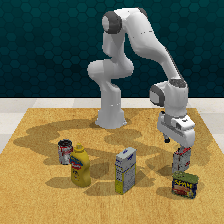

In [86]:
Image.fromarray(data['imgs'][0])

In [85]:
data['imgs'][0].transpose(2,0,1)

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [210, 201, 208, ..., 200, 196, 207],
        [203, 195, 203, ..., 205, 198, 196],
        [207, 209, 205, ..., 204, 195, 206]],

       [[ 55,  50,  48, ...,  55,  55,  55],
        [ 55,  55,  47, ...,  54,  54,  54],
        [ 54,  55,  54, ...,  54,  54,  54],
        ...,
        [169, 153, 166, ..., 158, 159, 172],
        [157, 145, 157, ..., 168, 161, 155],
        [167, 172, 158, ..., 171, 157, 171]],

       [[ 60,  55,  54, ...,  59,  59,  59],
        [ 60,  60,  53, ...,  58,  58,  58],
        [ 60,  60,  57, ...,  58,  58,  58],
        ...,
        [ 88,  73,  85, ...,  80,  86,  95],
        [ 80,  66,  78, ...,  91,  86,  79],
        [ 88,  92,  79, ...,  96,  81,  92]]], dtype=uint8)

In [90]:
out_img = processor.image_processor.apply_transform(Image.fromarray(data['imgs'][0]))

In [91]:
out_img.shape

torch.Size([3, 224, 224])